In [98]:
import pandas as pd
from matplotlib import pyplot as plt
from TCGA_files import *
from gtex import get_gtex_tissue
import seaborn as sns
from hsbmpy import topic_distr_isample, topic_distr_sample,get_file, get_tissue_style
from TCGA_files import get_tcga_tissue

In [99]:
l = 4
#setup = '5000doc_0.25occ_fpkmweight_thr'
#setup='overlap_5000doc_0.25occ_fpkmweight_thr'
setup = 'oversigma_10tissue'
#label = 'disease_type'
labels = ['primary_site', 'secondary_site']
label=labels[0]
algorithm = "topsbm"
#directory = "/Volumes/GoogleDrive/My Drive/tesi_magistrale/tesi/results/hSBM/%s/"%(setup)
directory='/home/fvalle/phd/results/tcga/oversampling_10tissue/'
#directory='/home/fvalle/GoogleDrive/tesi_magistrale/tesi/merged/hsbm/'
#directory = "/Volumes/GoogleDrive/My Drive/tesi_magistrale/tesi/gtex/hsbm/oversigma_10tissue"

In [100]:
df = pd.read_csv("%s/%s/%s_level_%d_topic-dist.csv"%(directory,algorithm,algorithm,l))
df.head()

,i_doc,doc,Topic 1,Topic 2,Topic 3,Topic 4
0,0,00059756-2eca-4bfe-9cd0-,0.395881,0.121739,0.428833,0.053547
1,1,0006cd63-2533-46d9-b58d-,0.386541,0.130412,0.435576,0.047470
2,2,0085907d-7474-4aff-b001-,0.386986,0.123777,0.440313,0.048924
3,3,0094a627-a55f-48dc-bbc3-,0.367405,0.129534,0.466321,0.036740
4,4,00eb7c26-84fd-4ab9-93a1-,0.380973,0.120534,0.452002,0.046492


### Specific topic

In [4]:
topic = 15

In [ ]:
searchdf = df.sort_values(by="Topic %d"%topic, ascending=False).loc[:,['doc','Topic %d'%topic]]
searchdf.head()

In [ ]:
#datatotest = queryFiles([f[0]+'.FPKM.txt.gz' for f in searchdf.values[:30] if f[1]>0.1])
#datatotest = queryFiles([f[0] for f in searchdf.values[:10]])
datatotest = pd.DataFrame(columns=['primary_site','secondary_site'])
for file in [f[0] for f in searchdf.values[:10]]:
    datatotest=datatotest.append(get_gtex_tissue(file))
datatotest

In [ ]:
makeTopicPie(datatotest, l, ['primary_site','secondary_site'])

In [ ]:
df_file=pd.read_csv("files.dat", index_col=[0])
samples = []
for sample in df['doc']:
    if 'Lung' in get_gtex_tissue(sample)['primary_site']:
        samples.append(sample)

In [ ]:
tissuedf = df[df['doc'].isin(samples)].drop('i_doc', axis=1)
tissuedf.mean(axis=0).sort_values(ascending=False)

## topic distr

In [ ]:
for idoc in searchdf.index.values[:5]:
    fig=plt.figure()
    ax=fig.subplots()
    topic_distr_isample(idoc,df,ax)
    plt.show()
    fig.savefig("topic_distr_%d.png"%idoc)

In [ ]:
for idoc in np.random.randint(len(df.index), size=10):
    topic_distr_isample(idoc, df)

## Topic distr

### kl

In [24]:
l=3

In [ ]:
df_kl = pd.read_csv("%s/topsbm/topic-kl_%d.csv"%(directory,l), header=None)
df_kl.columns = ['first', 'second', 'kl']
df_kl.head()

In [ ]:
df_cluster = pd.read_csv("%s/topsbm/topsbm_level_%d_clusters.csv"%(directory,l))
df_topics = pd.read_csv("%s/topsbm/topsbm_level_%d_topic-dist.csv"%(directory,l)).loc[:,df.columns[2:]]
df_files = pd.read_csv("%s/files.dat"%(directory), index_col=[0], header=0)

In [ ]:
bins = np.linspace(-0.025,1.025,40)

In [ ]:
sites = df_files['primary_site'].unique()
df_tissue_kl = pd.DataFrame(index=sites, columns=sites, dtype=float)

In [ ]:
for tissue_row in sites:
    cluster_row = df_files[df_files['primary_site']==tissue_row].index.values
    for tissue_column in sites:
        print(tissue_row, tissue_column)
        cluster_column = df_files[df_files['primary_site']==tissue_column].index.values
        datarc = df_kl[(df_kl['first'].isin(cluster_row) & df_kl['second'].isin(cluster_column))]['kl'].values
        datacr = df_kl[(df_kl['first'].isin(cluster_column) & df_kl['second'].isin(cluster_row))]['kl'].values
        df_tissue_kl.at[tissue_row,tissue_column]=(np.average(np.concatenate((datarc,datacr))))

In [ ]:
h = sns.clustermap(df_tissue_kl.dropna(axis=0,how='all').dropna(axis=1, how='any'), cmap=sns.diverging_palette(15,250, n=15), metric='euclidean')
dn = h.dendrogram_col.dendrogram
h.fig.savefig("%s/topic_distr_kl_map.pdf"%directory)

In [ ]:
import scipy.cluster.hierarchy as shc
fig = plt.figure(figsize=(12,8))
ax = fig.subplots()
ax.set_xlabel("kl correlation", fontsize=16)
dend = shc.dendrogram(h.dendrogram_col.linkage, labels=df_tissue_kl.columns, orientation='right', distance_sort='discending', ax=ax)
fig.savefig("%s/topic_dist_dendogram_level(%d).pdf"%(directory,l))

### Topic maps

In [110]:
l=3

In [26]:
df_topics = pd.read_csv("%s/%s/%s_level_%d_topic-dist.csv"%(directory,algorithm,algorithm,l))
df_files = pd.read_csv("%s/files.dat"%directory, index_col=0)
df_topics.set_index('doc', inplace=True)
df_topics.insert(0,'tissue','')
df_topics.drop('i_doc', axis=1, inplace=True)
for sample in df_topics.index.values:
    df_topics.at[sample,'tissue']=("%s"%(get_file(sample,df_files)['primary_site']))

<Figure size 432x288 with 0 Axes>

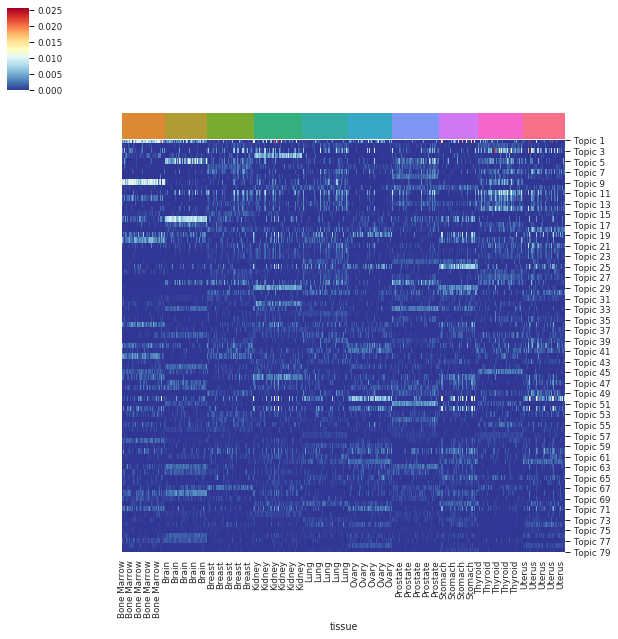

In [27]:
df_cmap = df_topics.sort_values(by='tissue').set_index('tissue').transpose()
df_cmap = df_cmap.subtract(df_cmap.mean(axis=1),axis=0)
#create a color palette with the same number of colors as unique values in the Source column
network_pal = sns.color_palette('husl',n_colors=len(df_cmap.columns))

#Create a dictionary where the key is the category and the values are the
#colors from the palette we just created
network_lut = dict(zip(df_cmap.columns, network_pal))
network_col = df_cmap.columns.map(network_lut)

fig = plt.figure()
cm = sns.clustermap(df_cmap, row_cluster=False, col_cluster=False, metric='euclidean', vmin=0, cmap='RdYlBu_r', col_colors=network_col)
cm.fig.savefig("%s/MAP_level%d.png"%(directory,l))

In [28]:
df_topics = pd.read_csv("%s/%s/%s_level_%d_topic-dist.csv"%(directory,algorithm, algorithm,l))
df_topics.drop('i_doc', axis=1, inplace=True)
df_topics.set_index('doc', inplace=True)
for sample in df_topics.index.values:
    df_topics.at[sample,'tissue']="%s"%(get_file(sample,df_files)['primary_site'])

Bone Marrow
Breast
Prostate
Uterus
Brain
Ovary
Stomach
Lung
Kidney
Thyroid
Lymph Nodes
Soft Tissue
Esophagus


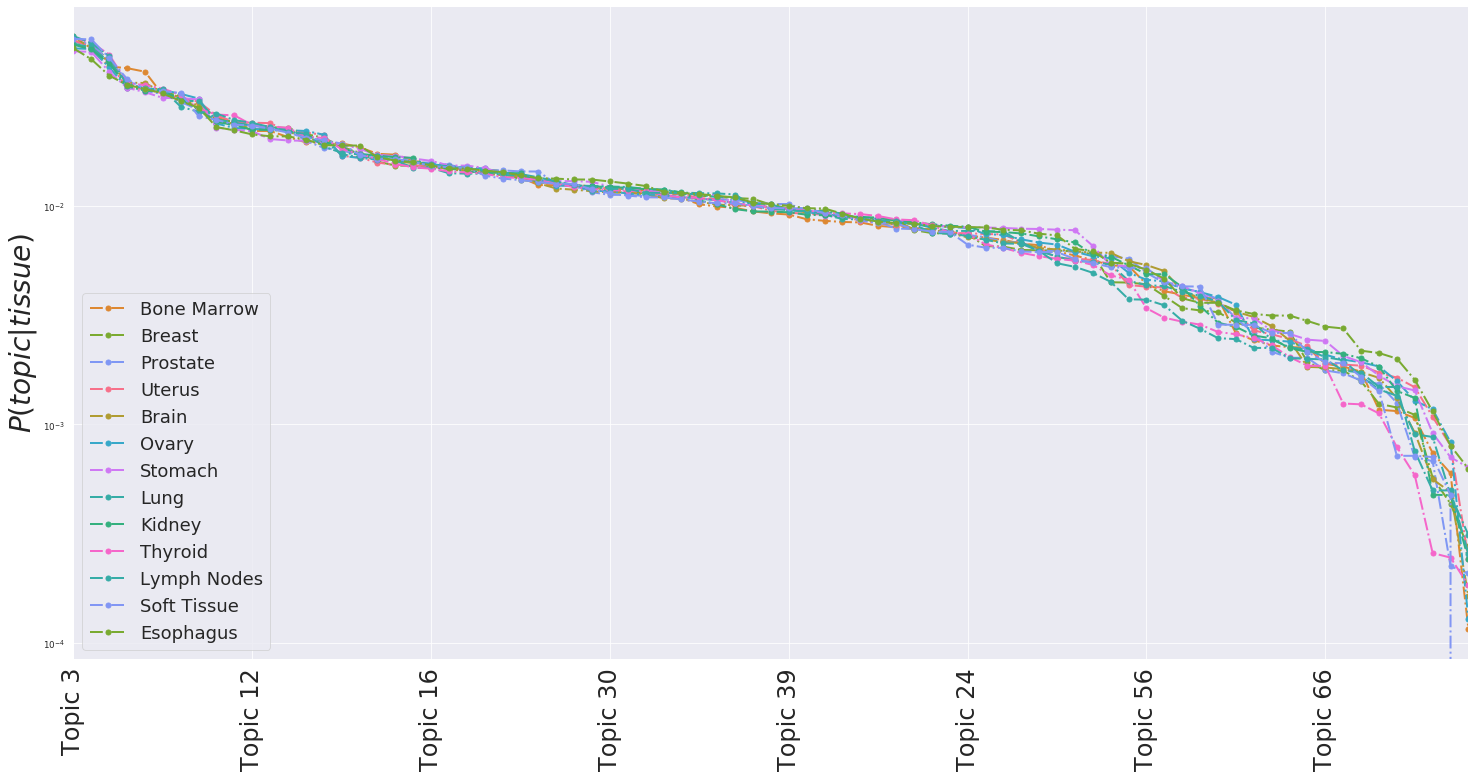

In [29]:
fig = plt.figure(figsize=(25,12))
for tissue in df_topics['tissue'].unique():
    print(tissue)
    marker, c, ls = get_tissue_style(tissue)
    try:
        df_topics[df_topics['tissue']==tissue].loc[:,df_topics.columns[0:]].mean(axis=0).sort_values(ascending=False).plot(ls=ls,marker=marker, lw=2, ms=10, label=tissue, c=network_lut[df_files[df_files['primary_site']==tissue]['primary_site'][0]])
    except:
        pass
plt.xticks(rotation=90, fontsize=24)
plt.ylabel("$P(topic | tissue)$", fontsize=28)
plt.legend(fontsize=18)
#plt.xscale('log')
plt.yscale('log')
plt.show()
fig.savefig("%s/%s/lifeplot.pdf"%(directory,algorithm))

In [30]:
expressedtopics = df_topics.drop('tissue', axis=1).mean(axis=0).sort_values(ascending=False).index

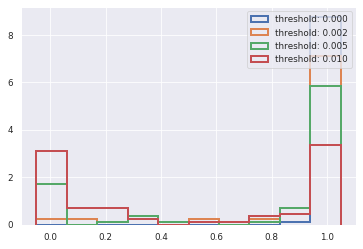

In [12]:
fig=plt.figure()
for thr in [0, 0.002, 0.005,0.01]:
    plt.hist(df_topics.drop('tissue', axis=1).transpose().apply(lambda x: len(x[x>thr])/float(len(x)), axis=1), histtype='step', density=True, range=(-0.05,1.05), bins=10, lw=2, label="threshold: %.3f"%thr)
plt.legend()
fig.savefig("%s/%s/distr_topicU.pdf"%(directory,algorithm))

In [13]:
topic_table = df_topics.drop('tissue', axis=1).transpose()
topic_table.insert(0,'occ', df_topics.drop('tissue', axis=1).transpose().apply(lambda x: len(x[x>0.002])/float(len(x)), axis=1).values)

In [14]:
low_occ_topics = topic_table[topic_table['occ']<0.05].index.values
#low_occ_topics = ["Topic 19", "Topic 153", "Topic 185","Topic 201"]
l_topics_i = [int(t[6:])-1 for t in low_occ_topics]
#l_topics_i = np.random.randint(0,100,10)

In [102]:
import findspark
findspark.init()
import pyspark as spark
import tensorflow as tf
from pyspark.sql.functions import udf,col
from pyspark.sql.types import StringType
sc = spark.SparkContext()
sql = spark.SQLContext(sc)

ValueError: Cannot run multiple SparkContexts at once; existing SparkContext(app=pyspark-shell, master=local[*]) created by __init__ at <ipython-input-15-84a6d31af224>:7 

In [113]:
df_files_pd = pd.read_csv("%s/files.dat"%directory, index_col=0)
df_topics = sql.read.option("header","true").csv("%s/%s/%s_level_%d_topic-dist.csv"%(directory,algorithm,algorithm,l))
df_topic_list = sql.read.option("header","true").csv("%s/%s/%s_level_%d_topics.csv"%(directory,algorithm,algorithm,l))
df_files = sql.read.option("header","true").csv("%s/files.dat"%(directory))
df_files.registerTempTable("file")
df_topics = df_topics.withColumn('status', udf(lambda x: 'healthy' if 'GTEX' in x else 'tumour', StringType())(col('doc')))
df_topics = df_topics.withColumn('tissue', udf(lambda x: get_file(x, df_files_pd)[labels[0]], StringType())(col('doc')))
df_topics = df_topics.withColumn('second_tissue', udf(lambda x: get_file(x, df_files_pd)[labels[1]], StringType())(col('doc')))
df_topics.registerTempTable("topic")

### only health vs disease

In [104]:
dftf_h = tf.convert_to_tensor(sql.sql("SELECT * FROM topic WHERE status='healthy'").toPandas().drop(['doc','i_doc', 'status', 'tissue','second_tissue'], axis=1).astype(float).values)
dftf_d = tf.convert_to_tensor(sql.sql("SELECT * FROM topic WHERE status='tumour'").toPandas().drop(['doc','i_doc', 'status', 'tissue','second_tissue'], axis=1).astype(float).values)

Py4JJavaError: An error occurred while calling o31008.collectToPython.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 2070.0 failed 1 times, most recent failure: Lost task 0.0 in stage 2070.0 (TID 10571, localhost, executor driver): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/home/fvalle/anaconda3/envs/phd/lib/python3.6/site-packages/pandas/core/indexes/base.py", line 4736, in get_value
    return libindex.get_value_box(s, key)
  File "pandas/_libs/index.pyx", line 51, in pandas._libs.index.get_value_box
  File "pandas/_libs/index.pyx", line 47, in pandas._libs.index.get_value_at
  File "pandas/_libs/util.pxd", line 98, in pandas._libs.util.get_value_at
  File "pandas/_libs/util.pxd", line 83, in pandas._libs.util.validate_indexer
TypeError: 'str' object cannot be interpreted as an integer

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/spark/spark-2.4.4-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/worker.py", line 377, in main
    process()
  File "/usr/local/spark/spark-2.4.4-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/worker.py", line 372, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/usr/local/spark/spark-2.4.4-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/serializers.py", line 345, in dump_stream
    self.serializer.dump_stream(self._batched(iterator), stream)
  File "/usr/local/spark/spark-2.4.4-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/serializers.py", line 141, in dump_stream
    for obj in iterator:
  File "/usr/local/spark/spark-2.4.4-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/serializers.py", line 334, in _batched
    for item in iterator:
  File "<string>", line 1, in <lambda>
  File "/usr/local/spark/spark-2.4.4-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/worker.py", line 85, in <lambda>
    return lambda *a: f(*a)
  File "/usr/local/spark/spark-2.4.4-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/util.py", line 99, in wrapper
    return f(*args, **kwargs)
  File "<ipython-input-103-b1a904657669>", line 8, in <lambda>
  File "/home/fvalle/anaconda3/envs/phd/lib/python3.6/site-packages/pandas/core/series.py", line 1068, in __getitem__
    result = self.index.get_value(self, key)
  File "/home/fvalle/anaconda3/envs/phd/lib/python3.6/site-packages/pandas/core/indexes/base.py", line 4744, in get_value
    raise e1
  File "/home/fvalle/anaconda3/envs/phd/lib/python3.6/site-packages/pandas/core/indexes/base.py", line 4730, in get_value
    return self._engine.get_value(s, k, tz=getattr(series.dtype, "tz", None))
  File "pandas/_libs/index.pyx", line 80, in pandas._libs.index.IndexEngine.get_value
  File "pandas/_libs/index.pyx", line 88, in pandas._libs.index.IndexEngine.get_value
  File "pandas/_libs/index.pyx", line 131, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/hashtable_class_helper.pxi", line 1607, in pandas._libs.hashtable.PyObjectHashTable.get_item
  File "pandas/_libs/hashtable_class_helper.pxi", line 1614, in pandas._libs.hashtable.PyObjectHashTable.get_item
KeyError: 'secondary_site'

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:456)
	at org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$1.read(PythonUDFRunner.scala:81)
	at org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$1.read(PythonUDFRunner.scala:64)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:410)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$12.hasNext(Iterator.scala:440)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage3.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anonfun$13$$anon$1.hasNext(WholeStageCodegenExec.scala:636)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$2.apply(SparkPlan.scala:255)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$2.apply(SparkPlan.scala:247)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitionsInternal$1$$anonfun$apply$24.apply(RDD.scala:836)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitionsInternal$1$$anonfun$apply$24.apply(RDD.scala:836)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:123)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:408)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:414)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1889)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1877)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1876)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1876)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:926)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:926)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:926)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2110)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2059)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2048)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:737)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2061)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2082)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2101)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2126)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1.apply(RDD.scala:945)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:363)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:944)
	at org.apache.spark.sql.execution.SparkPlan.executeCollect(SparkPlan.scala:299)
	at org.apache.spark.sql.Dataset$$anonfun$collectToPython$1.apply(Dataset.scala:3263)
	at org.apache.spark.sql.Dataset$$anonfun$collectToPython$1.apply(Dataset.scala:3260)
	at org.apache.spark.sql.Dataset$$anonfun$52.apply(Dataset.scala:3370)
	at org.apache.spark.sql.execution.SQLExecution$$anonfun$withNewExecutionId$1.apply(SQLExecution.scala:78)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:125)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:73)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:3369)
	at org.apache.spark.sql.Dataset.collectToPython(Dataset.scala:3260)
	at sun.reflect.GeneratedMethodAccessor144.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/home/fvalle/anaconda3/envs/phd/lib/python3.6/site-packages/pandas/core/indexes/base.py", line 4736, in get_value
    return libindex.get_value_box(s, key)
  File "pandas/_libs/index.pyx", line 51, in pandas._libs.index.get_value_box
  File "pandas/_libs/index.pyx", line 47, in pandas._libs.index.get_value_at
  File "pandas/_libs/util.pxd", line 98, in pandas._libs.util.get_value_at
  File "pandas/_libs/util.pxd", line 83, in pandas._libs.util.validate_indexer
TypeError: 'str' object cannot be interpreted as an integer

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/spark/spark-2.4.4-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/worker.py", line 377, in main
    process()
  File "/usr/local/spark/spark-2.4.4-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/worker.py", line 372, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/usr/local/spark/spark-2.4.4-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/serializers.py", line 345, in dump_stream
    self.serializer.dump_stream(self._batched(iterator), stream)
  File "/usr/local/spark/spark-2.4.4-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/serializers.py", line 141, in dump_stream
    for obj in iterator:
  File "/usr/local/spark/spark-2.4.4-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/serializers.py", line 334, in _batched
    for item in iterator:
  File "<string>", line 1, in <lambda>
  File "/usr/local/spark/spark-2.4.4-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/worker.py", line 85, in <lambda>
    return lambda *a: f(*a)
  File "/usr/local/spark/spark-2.4.4-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/util.py", line 99, in wrapper
    return f(*args, **kwargs)
  File "<ipython-input-103-b1a904657669>", line 8, in <lambda>
  File "/home/fvalle/anaconda3/envs/phd/lib/python3.6/site-packages/pandas/core/series.py", line 1068, in __getitem__
    result = self.index.get_value(self, key)
  File "/home/fvalle/anaconda3/envs/phd/lib/python3.6/site-packages/pandas/core/indexes/base.py", line 4744, in get_value
    raise e1
  File "/home/fvalle/anaconda3/envs/phd/lib/python3.6/site-packages/pandas/core/indexes/base.py", line 4730, in get_value
    return self._engine.get_value(s, k, tz=getattr(series.dtype, "tz", None))
  File "pandas/_libs/index.pyx", line 80, in pandas._libs.index.IndexEngine.get_value
  File "pandas/_libs/index.pyx", line 88, in pandas._libs.index.IndexEngine.get_value
  File "pandas/_libs/index.pyx", line 131, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/hashtable_class_helper.pxi", line 1607, in pandas._libs.hashtable.PyObjectHashTable.get_item
  File "pandas/_libs/hashtable_class_helper.pxi", line 1614, in pandas._libs.hashtable.PyObjectHashTable.get_item
KeyError: 'secondary_site'

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:456)
	at org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$1.read(PythonUDFRunner.scala:81)
	at org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$1.read(PythonUDFRunner.scala:64)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:410)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$12.hasNext(Iterator.scala:440)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage3.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anonfun$13$$anon$1.hasNext(WholeStageCodegenExec.scala:636)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$2.apply(SparkPlan.scala:255)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$2.apply(SparkPlan.scala:247)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitionsInternal$1$$anonfun$apply$24.apply(RDD.scala:836)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitionsInternal$1$$anonfun$apply$24.apply(RDD.scala:836)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:123)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:408)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:414)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more


In [ ]:
with tf.Session() as sess:
    results = sess.run(tf.sort([tf.math.reduce_mean(dftf_h,0),tf.math.reduce_mean(dftf_d,0)], axis=1, direction='DESCENDING'))

In [ ]:
fig = plt.figure(figsize=(20,10))
plt.plot(results[0], marker='o', lw=0.1)
plt.plot(results[1],marker='x', lw=0.1)
plt.yscale('log')
plt.xscale('log')
plt.show()

In [114]:
df_topics

DataFrame[i_doc: string, doc: string, Topic 1: string, Topic 2: string, Topic 3: string, Topic 4: string, Topic 5: string, Topic 6: string, Topic 7: string, Topic 8: string, Topic 9: string, Topic 10: string, Topic 11: string, Topic 12: string, Topic 13: string, Topic 14: string, Topic 15: string, Topic 16: string, Topic 17: string, Topic 18: string, Topic 19: string, Topic 20: string, Topic 21: string, Topic 22: string, Topic 23: string, Topic 24: string, Topic 25: string, Topic 26: string, Topic 27: string, Topic 28: string, Topic 29: string, Topic 30: string, Topic 31: string, Topic 32: string, Topic 33: string, Topic 34: string, Topic 35: string, Topic 36: string, Topic 37: string, Topic 38: string, Topic 39: string, Topic 40: string, Topic 41: string, Topic 42: string, Topic 43: string, Topic 44: string, Topic 45: string, Topic 46: string, Topic 47: string, Topic 48: string, Topic 49: string, Topic 50: string, Topic 51: string, Topic 52: string, Topic 53: string, Topic 54: string,

In [106]:
topic_cols=df_topics.columns[2:-3]
look_for = ['colon', 'colon-gtex','colon-tcga']
exprs = {x: "avg" for x in topic_cols}
df_tissue_healthy=df_topics.filter(col('tissue')==look_for[0]).select(topic_cols).agg(exprs).toPandas()[["avg(%s)"%topic for topic in topic_cols]]
df_tissue_disease=df_topics.filter(col('tissue')!=look_for[2]).select(topic_cols).agg(exprs).toPandas()[["avg(%s)"%topic for topic in topic_cols]]

In [107]:
df_topics.groupby('tissue').count().show()

+-----------+-----+
|     tissue|count|
+-----------+-----+
|Soft Tissue|    2|
|Lymph Nodes|    2|
|     Kidney|   86|
|   Prostate|   82|
|  Esophagus|    2|
|    Stomach|   70|
|    Thyroid|   80|
|      Brain|   76|
|     Uterus|   75|
|       Lung|   80|
|Bone Marrow|   78|
|      Ovary|   79|
|     Breast|   81|
+-----------+-----+



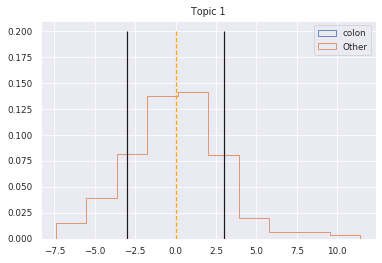

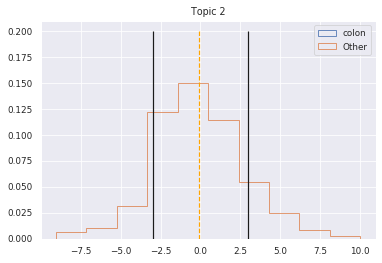

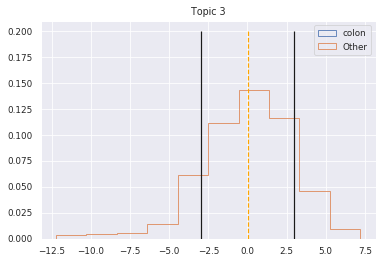

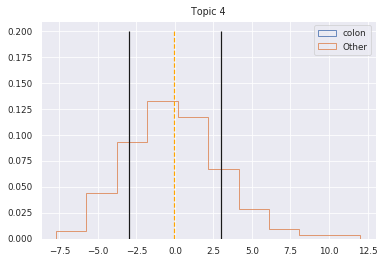

In [111]:
means = df_topics.groupby(['status','tissue']).agg(exprs).agg({x: 'avg' for x in ["avg(%s)"%t for t in topic_cols]}).toPandas()[["avg(avg(%s))"%topic for topic in topic_cols]]
means.columns=topic_cols
sigmas = df_topics.groupby(['status','tissue']).agg({x: "std" for x in topic_cols}).agg({x: 'std' for x in ["stddev(%s)"%t for t in topic_cols]}).toPandas()[["stddev(stddev(%s))"%topic for topic in topic_cols]]
sigmas.columns=topic_cols
df_topics_grouped = df_topics.groupby(['status','second_tissue']).agg(exprs)
for topic in topic_cols:
    plt.figure()
    plt.title(topic)
    healthy=(df_topics.filter(col('tissue')==look_for[0]).select([topic]).toPandas().astype(float)-means[topic].values)/sigmas[topic].values
    disease=(df_topics.filter(col('tissue')!=look_for[0]).select([topic]).toPandas().astype(float)-means[topic].values)/sigmas[topic].values
    plt.hist(healthy.values.T[0], density=True, histtype='step', label=look_for[0])
    plt.hist(disease.values.T[0], density=True, histtype='step', label='Other')
    plt.vlines([healthy.mean(),disease.mean().values],0,0.2,colors=['blue','orange'], linestyles=['dashed','dashed'])
    plt.vlines([-3,3],0,0.2,colors=['k','k'])
    plt.legend()
    plt.show()

In [116]:
for g in df_topic_list.select("Topic 5").dropna().toPandas().values.T[0]:
    print(g)

ENSG00000120049
ENSG00000105649
ENSG00000108309
ENSG00000163661
ENSG00000103740
ENSG00000180638
ENSG00000099822
ENSG00000013297
ENSG00000161082
ENSG00000164972
ENSG00000158055
ENSG00000162188
ENSG00000174844
ENSG00000185634
ENSG00000112309
ENSG00000122012
ENSG00000164106
ENSG00000186710
ENSG00000160716
ENSG00000184524
ENSG00000163380
ENSG00000154118
ENSG00000143318
ENSG00000174521
ENSG00000128564
ENSG00000189056
ENSG00000136541
ENSG00000142408
ENSG00000135472
ENSG00000107147
ENSG00000149926
ENSG00000213023
ENSG00000136531
ENSG00000176884
ENSG00000188916
ENSG00000118160
ENSG00000144550
ENSG00000122733
ENSG00000054356
ENSG00000070808
ENSG00000171724
ENSG00000138379
ENSG00000063015
ENSG00000134376
ENSG00000164690
ENSG00000132702
ENSG00000197106
ENSG00000162374
ENSG00000129159
ENSG00000178233
ENSG00000123560
ENSG00000188523
ENSG00000183798
ENSG00000187957
ENSG00000124194
ENSG00000080166
ENSG00000135502
ENSG00000163263
ENSG00000175093
ENSG00000188580
ENSG00000101542
ENSG00000090932
ENSG0000

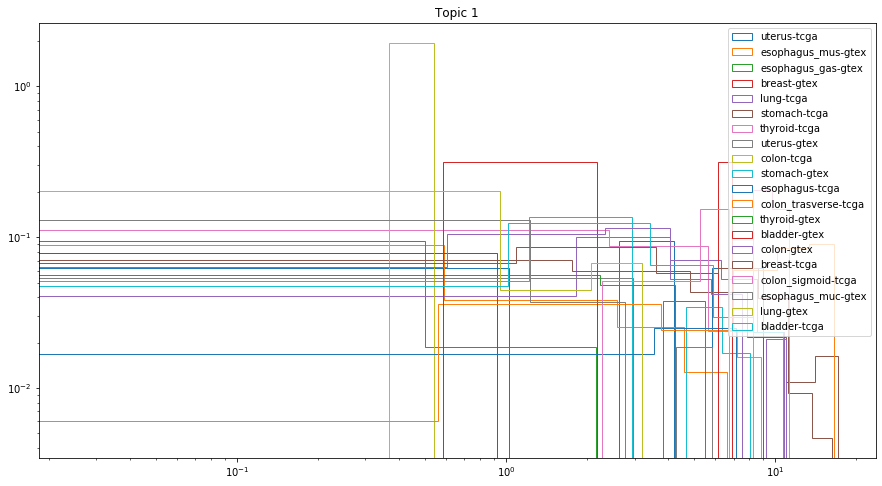

E1002 10:06:58.805158 140482128168768 ultratb.py:155] Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/fvalle/anaconda3/envs/phd/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cc884208f421>", line 5, in <module>
    tissue_spec=(df_topics.filter(col('second_tissue')==tissue).select([topic]).toPandas().astype(float)-means[topic].values)/sigmas[topic].values
  File "/usr/local/spark/spark-2.4.4-bin-hadoop2.7/python/pyspark/sql/dataframe.py", line 2143, in toPandas
    pdf = pd.DataFrame.from_records(self.collect(), columns=self.columns)
  File "/usr/local/spark/spark-2.4.4-bin-hadoop2.7/python/pyspark/sql/dataframe.py", line 534, in collect
    sock_info = self._jdf.collectToPython()
  File "/usr/local/spark/spark-2.4.4-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1255, in __call__
    answer = self.gateway_client.send_command(command)
  File "/usr/local/spark/spark-2.4.4-bin-hadoop2.7/python/lib

KeyboardInterrupt: 

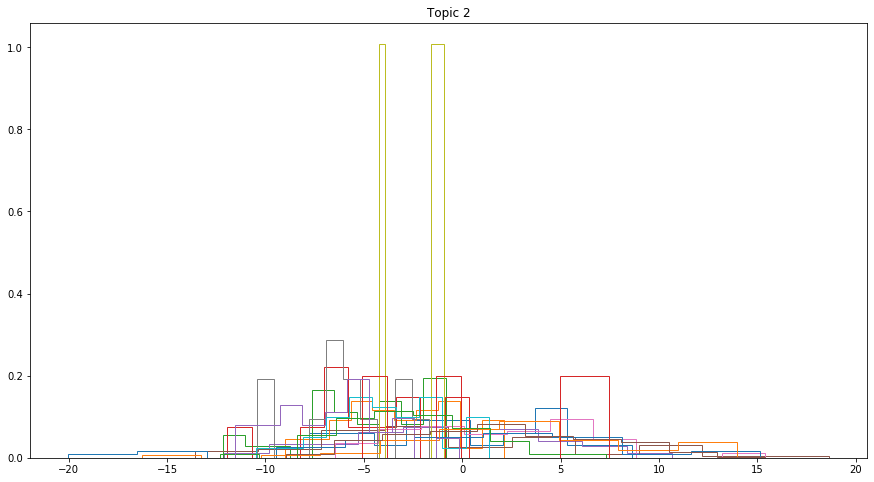

In [13]:
for topic in topic_cols:
    plt.figure(figsize=(15,8))
    plt.title(topic)
    for tissue in df_topics.select('second_tissue').distinct().toPandas().values.T[0]:
        tissue_spec=(df_topics.filter(col('second_tissue')==tissue).select([topic]).toPandas().astype(float)-means[topic].values)/sigmas[topic].values
        plt.hist(tissue_spec.values.T[0], density=True, histtype='step', label=tissue)
    plt.xscale('log')
    plt.yscale('log')
    plt.legend()
    plt.show()

In [293]:
df_topics_grouped = df_topics.groupby('second_tissue').agg({x: 'avg' for x in topic_cols}).toPandas().set_index('second_tissue')[["avg(%s)"%t for t in topic_cols]].transpose()
df_topics_grouped.index=topic_cols

In [320]:
df_cmap.mean(axis=1)-

Topic 1    -1.561251e-17
Topic 2    -3.469447e-18
Topic 3     3.816392e-17
Topic 4    -1.734723e-18
Topic 5    -8.673617e-19
Topic 6    -9.974660e-18
Topic 7    -1.084202e-19
Topic 8     5.421011e-20
Topic 9     1.084202e-19
Topic 10    1.355253e-20
Topic 11    0.000000e+00
Topic 12    3.252607e-19
Topic 13    5.421011e-20
Topic 14   -3.252607e-19
Topic 15   -1.084202e-19
Topic 16    0.000000e+00
Topic 17   -1.355253e-20
Topic 18   -5.421011e-20
Topic 19    5.421011e-20
Topic 20   -1.355253e-19
Topic 21    0.000000e+00
Topic 22   -1.355253e-20
Topic 23    0.000000e+00
Topic 24   -2.710505e-20
Topic 25    2.032879e-20
dtype: float64

<Figure size 432x288 with 0 Axes>

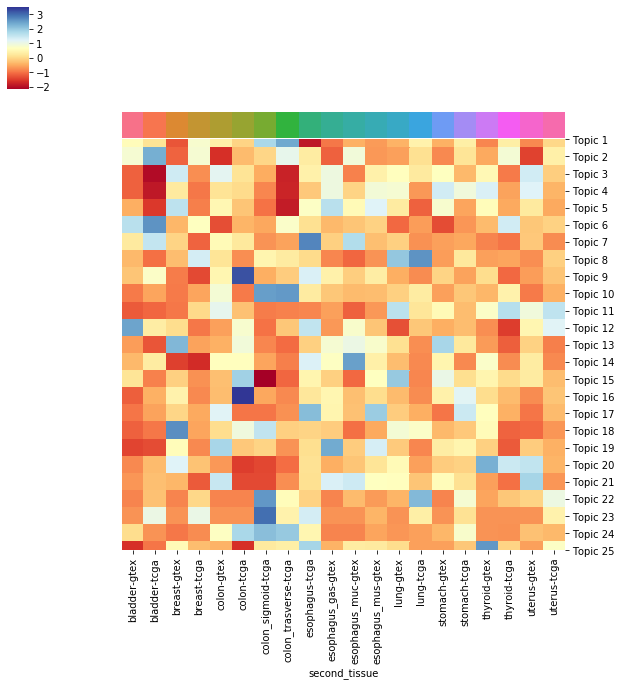

In [328]:
df_cmap = df_topics_grouped
df_cmap=df_cmap.subtract(df_cmap.mean(axis=1), axis=0).divide(df_cmap.std(axis=1), axis=0)
df_cmap.sort_index(axis=1, inplace=True)
#df_cmap.sort_values(by=[c for c in df_cmap.columns[::2]], inplace=True)
#create a color palette with the same number of colors as unique values in the Source column
network_pal = sns.color_palette('husl',n_colors=len(df_cmap.columns))

#Create a dictionary where the key is the category and the values are the
#colors from the palette we just created
network_lut = dict(zip(df_cmap.columns, network_pal))
network_col = df_cmap.columns.map(network_lut)

fig = plt.figure()
cm = sns.clustermap(df_cmap, row_cluster=False, col_cluster=False, metric='euclidean', cmap='RdYlBu', col_colors=network_col)
cm.fig.savefig("%s/MAP_level%d.png"%(directory,l))

/home/fvalle/anaconda3/envs/phd/lib/python3.6/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/fvalle/anaconda3/envs/phd/lib/python3.6/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


AttributeError: 'Rectangle' object has no property 'marker'

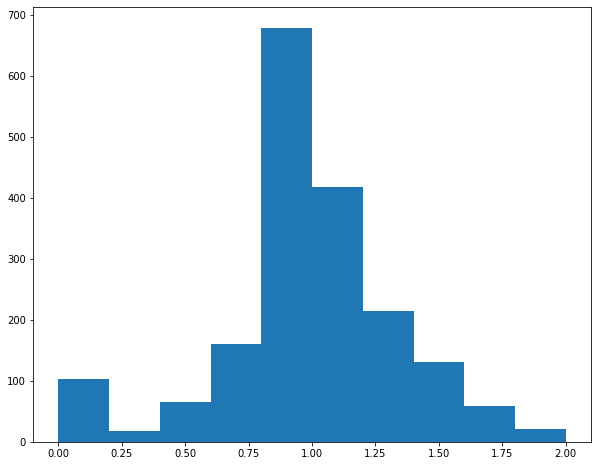

In [121]:
fig=plt.figure(figsize=(10,8))
#plt.plot((df_tissue).values[0], label=look_for[0], ls='--', ms=10)
plt.hist((df_tissue_healthy).values[0], label=look_for[1], marker='x', lw=0.5, ms=10)
plt.hist((df_tissue_disease).values[0], label=look_for[2], marker='x', lw=0.5, ms=10)
plt.xticks(ticks=np.arange(len(topic_cols)), labels=topic_cols, rotation=90)
#plt.yscale('log')
plt.legend(fontsize=20)
plt.show()

In [81]:
(df_tissue_healthy-df_tissue).values

array([[-1.54573159e-02, -1.91396894e-02,  2.33624794e-02,
         3.51529149e-03,  7.06638062e-03, -3.01455005e-03,
         7.50417231e-04, -4.65689332e-04,  1.82729614e-04,
        -2.05355654e-05, -3.98208907e-04,  5.24960296e-04,
         1.05590083e-03,  1.18734643e-04,  1.28504763e-04,
         1.68468643e-04,  2.43034498e-05,  8.93780276e-04,
         3.09631100e-04,  3.25361327e-04,  1.93212619e-04,
        -5.61370249e-05, -8.61719815e-05, -2.76223246e-05,
         4.57641189e-05]])

### all

In [ ]:
df_all = tf.convert_to_tensor(sql.sql("SELECT * FROM topic").toPandas().drop(['i_doc', 'doc', 'status', 'tissue','second_tissue'], axis=1).astype(float))

In [ ]:
#normed_df = tf.divide(tf.subtract(df_all,tf.reduce_mean(df_all,0)),tf.math.reduce_mean(df_all, 0))
normed_df = tf.divide(tf.abs(tf.subtract(df_all,tf.reduce_mean(df_all,0))),tf.sqrt(tf.math.reduce_variance(df_all, 0)))
#normed_df = tf.divide(tf.math.divide(df_all,tf.reduce_mean(df_all,0)), tf.cast(tf.shape(df_all)[0], tf.float64))
#normed_df = tf.math.multiply(df_all,tf.reduce_mean(df_all,0))

In [ ]:
with tf.Session() as sess:
    result = sess.run([normed_df])

In [ ]:
fig=plt.figure(figsize=(30,15))
label = 'second_tissue'
for tissue in ['breast-gtex', 'breast-tcga', 'colon-gtex', 'colon-tcga','thyroid-gtex','thyroid-tcga']:
    print(tissue)
    marker, c, ls = get_tissue_style(tissue)
    i_docs = sql.sql("SELECT i_doc, %s FROM topic WHERE %s='%s'"%(label, label,tissue)).select('i_doc').toPandas().astype(int).values.T[0]
    plt.plot(np.mean(result[0][i_docs],axis=0)[l_topics_i], marker=marker, lw=0.8, ls=ls, label=tissue, ms=18, c=c)
    #plt.hist(np.mean(result[0][i_docs],axis=0)[l_topics_i])
plt.legend(fontsize=18, ncol=3)
plt.ylabel("$\\frac{\\left|P(topic | tissue) - mean\\right|}{\sigma}$", fontsize=44)
plt.xticks(np.linspace(0,len(l_topics_i)-1,num=len(l_topics_i)), low_occ_topics, rotation=90, fontsize=24)
#plt.yscale('log')
plt.show()
fig.savefig("%s/lifeplot_normalised_level%d_hd.pdf"%(directory,l))

In [ ]:
fig=plt.figure(figsize=(30,15))
label='tissue'
for tissue in df_topics.select(label).distinct().toPandas().values.T[0][:]:
    print(tissue)
    marker, c, ls = get_tissue_style(tissue)
    i_docs = sql.sql("SELECT i_doc, %s FROM topic WHERE %s='%s'"%(label, label,tissue)).select('i_doc').toPandas().astype(int).values.T[0]
    fig=plt.figure(figsize=(30,15))
    plt.plot(np.mean(result[0][i_docs],axis=0)[l_topics_i], marker=marker, lw=0.1, ls=ls, label=tissue, ms=18, c=c)
    #plt.hist(np.mean(result[0][i_docs],axis=0)[l_topics_i])
    plt.legend(fontsize=16, ncol=4)
    plt.ylabel("$\\frac{\\left|P(topic | tissue) - mean\\right|}{\sigma}$", fontsize=24)
    plt.xticks(ticks=np.linspace(0,len(l_topics_i)-1,num=len(l_topics_i)), labels=low_occ_topics, rotation=90, fontsize=24)
    plt.show()
    fig.savefig("%s/%s/lifeplot_normalised_%s_%s.pdf"%(directory,algorithm,label,tissue))

In [ ]:
import importlib, hsbmpy
importlib.reload(hsbmpy)
from hsbmpy import get_tissue_style

In [ ]:
for tissue in df_topics.select(label).distinct().toPandas().values.T[0][:]:
    print(tissue)
    fig=plt.figure()
    plt.title(tissue)
    df_visual = sql.sql("SELECT * FROM topic WHERE tissue='%s'"%tissue).toPandas().drop(['i_doc', 'doc', 'status', 'tissue','second_tissue'], axis=1).astype(float)
    width = np.zeros(len(df_visual.index))
    for t in df_visual.columns:
        plt.barh(df_visual.index.values,df_visual[t].values,left=width)
        width+=df_visual[t].values
    plt.show()
    fig.savefig("%s/%s/topicvisual_%s.png"%(directory,algorithm,tissue))

In [ ]:
tf.reset_default_graph()
sc.stop()

## metrics 

In [310]:
from sklearn.metrics import silhouette_score
from hsbmpy import get_cluster_given_l
import seaborn as sns
sns.set_palette("Set1")

In [311]:
df_files = pd.read_csv("%s/files.dat"%(directory), index_col=0)

In [312]:
l=4

In [313]:
df = pd.read_csv("%s/mainTable.csv"%(directory), index_col=0).transpose()
df.head()

,ENSG00000164266,ENSG00000206047,ENSG00000112303,ENSG00000177257,ENSG00000163464,ENSG00000223569,ENSG00000163221,ENSG00000090382,ENSG00000221852,ENSG00000066336,...,ENSG00000131482,ENSG00000168878,ENSG00000009765,ENSG00000228075,ENSG00000212901,ENSG00000198650,ENSG00000110777,ENSG00000196549,ENSG00000170893,ENSG00000086570
GTEX-1117F-0226-SM-5GZZ7,16,0,171,0,26,0,32,934,79,1106,...,3,49,26,6,15,16,30,3275,4,307
GTEX-111CU-1826-SM-5GZYN,2,0,124,0,68,0,131,2495,3,4048,...,6,76,21,22,2,10,11,4020,4,247
GTEX-111FC-0226-SM-5N9B8,6,0,151,0,22,0,1,1762,18,1795,...,1,29,3,6,0,1,41,2365,0,51
GTEX-111VG-2326-SM-5N9BK,24,0,484,0,39,0,36,21909,14,10834,...,3,59,2,48,0,6,30,11672,19,237
GTEX-111YS-2426-SM-5GZZQ,9,0,296,0,69,0,70,1180,5,1099,...,0,23,18,4,0,12,12,6795,1,93


In [314]:
silhouettes = {}
silhouettes['clusters_number']=[]
algorithm='topsbm'
metric='correlation'
for algorithm in ['topsbm', 'lda']:
    silhouettes['real_%s'%algorithm]=[]
    silhouettes['red_%s'%algorithm]=[]
    for level in np.arange(l+1):
        df_red = pd.read_csv("%s/%s/%s_level_%d_topic-dist.csv"%(directory,algorithm,algorithm,l)).drop('i_doc', axis=1)
        df_red['doc']=[get_file(sample,df_files).name for sample in df_red['doc']]
        df_red.set_index('doc', inplace=True)
        cluster = get_cluster_given_l(level, directory, algorithm=algorithm)
        if len(silhouettes['clusters_number'])==0:
            silhouettes['clusters_number'].append(len(cluster))
        predicted_labels = []
        for c in cluster:
            for sample in cluster[c]:
                try:
                    predicted_labels.append([get_file(sample,df_files).name,c])
                except:
                    print(sys.exc_info()[0])
                    print("error searching %s in %s" % (label,sample))
        predicted_labels=np.array(predicted_labels)
        predicted_labels=pd.DataFrame(data=predicted_labels, columns=[0,'label']).set_index(0).sort_index()
        print(len(cluster), len(df.index))
        df_real=df[df.index.isin(predicted_labels.index)].sort_index()
        df_red=df_red.loc[predicted_labels.index,:]
        if len(cluster)<2 or len(cluster)>len(df_real.index)-1:
            silhouettes['real_%s'%algorithm].append(np.nan)
            silhouettes['red_%s'%algorithm].append(np.nan)
            continue
        silhouettes['real_%s'%algorithm].append(silhouette_score(df_real.values,predicted_labels.values.ravel().astype(int), metric=metric))
        silhouettes['red_%s'%algorithm].append(silhouette_score(df_red.values,predicted_labels.values.ravel().astype(int), metric=metric))

1183 5878
263 5878
33 5878
10 5878
1 5878
1183 5878
263 5878
33 5878
10 5878
1 5878


In [315]:
with open('%s/clustersizes.txt'%directory) as f:
    xl=np.array(f.read().split(), dtype=int)

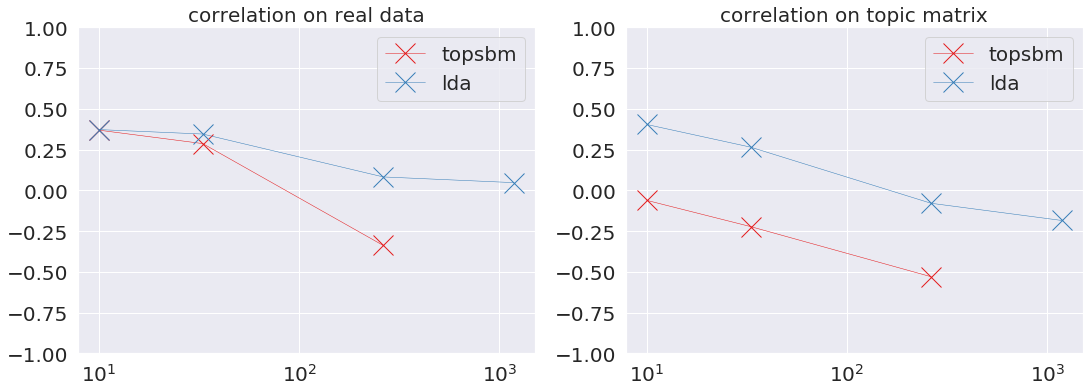

In [318]:
fig=plt.figure(figsize=(18,6))
ax = fig.subplots(1,2)
psets = {'marker':'x', 'ms':20, 'lw':0.5}
for algorithm in ['topsbm', 'lda']:
    ax[0].plot(xl,silhouettes['real_%s'%algorithm], label=algorithm, **psets)
    ax[1].plot(xl,silhouettes['red_%s'%algorithm], label=algorithm,  **psets)
ax[0].set_title("%s on real data"%metric, fontsize=20)
ax[1].set_title("%s on topic matrix"%metric, fontsize=20)
for axi in ax:
    axi.set_xscale('log')
    axi.set_ylim((-1,1))
    axi.tick_params(axis='both', which='major', labelsize=20)
    axi.legend(fontsize=20)
plt.show()
fig.savefig("%s/correlation_comparison.pdf"%directory)

In [286]:
silhouettes

{'clusters_number': [1183],
 'real_topsbm': [nan,
  -0.3381731342241183,
  0.28651397682657365,
  0.3688005235673174,
  nan],
 'red_topsbm': [nan,
  -0.5298364616548565,
  -0.22242819784859114,
  -0.06162600102002921,
  nan],
 'real_lda': [0.04712405299799496,
  0.08208409132526234,
  0.3451299123059717,
  0.3723814212699476,
  nan],
 'red_lda': [-0.18491314967876338,
  -0.07945934658178626,
  0.26475179778193714,
  0.4036613742760998,
  nan]}

In [276]:
predicted_labels

,label
0,
GTEX-1117F-2826-SM-5GZXL,0
GTEX-111CU-1026-SM-5EGIL,0
GTEX-111CU-1826-SM-5GZYN,0
GTEX-111VG-2326-SM-5N9BK,0
GTEX-111YS-0006-SM-5NQBE,0
...,...
GTEX-ZYW4-2126-SM-59HJ9,0
GTEX-ZYY3-0826-SM-5E44R,0
GTEX-ZZ64-0626-SM-5GZWR,0


In [246]:
pairwise.PAIRWISE_DISTANCE_FUNCTIONS

{'cityblock': <function sklearn.metrics.pairwise.manhattan_distances(X, Y=None, sum_over_features=True)>,
 'cosine': <function sklearn.metrics.pairwise.cosine_distances(X, Y=None)>,
 'euclidean': <function sklearn.metrics.pairwise.euclidean_distances(X, Y=None, Y_norm_squared=None, squared=False, X_norm_squared=None)>,
 'haversine': <function sklearn.metrics.pairwise.haversine_distances(X, Y=None)>,
 'l2': <function sklearn.metrics.pairwise.euclidean_distances(X, Y=None, Y_norm_squared=None, squared=False, X_norm_squared=None)>,
 'l1': <function sklearn.metrics.pairwise.manhattan_distances(X, Y=None, sum_over_features=True)>,
 'manhattan': <function sklearn.metrics.pairwise.manhattan_distances(X, Y=None, sum_over_features=True)>,
 'precomputed': None}